# 1.ICESAT-2有效波高显示

In [78]:
import pyproj
from  pyproj  import  CRS
import h5py
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
import glob
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
import pandas as pd

In [44]:
# 设置空间分辨率
resolution = 10000

# 将WGS 84坐标（4326）转化为等距圆柱投影（4088）
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS.from_epsg(4088)
crs2 = CRS.from_string("epsg:4088")
crs2 = CRS.from_proj4("+proj=latlon")
crs2 = CRS.from_user_input(4088)

transformer = pyproj.Transformer.from_crs(crs,crs2)
transformer_back = pyproj.Transformer.from_crs(crs2,crs)

In [45]:
# 获取数组的长和宽
def get_nlat_nlon_npaeqd(resolution):
    nlat, nlon =40000000/ resolution,40000000/ resolution
    nlat = np.int(nlat)
    nlon = np.int(nlon)
    return nlat, nlon
    
def get_nlat_nlon_cyl(resolution):
    nlat, nlon =40000000/ resolution,20000000/ resolution
    nlat = np.int(nlat)
    nlon = np.int(nlon)
    return nlat, nlon

# 获取用来存放数据的grid数组，及其对应的grid_num数组（用来存放一个格子中有多少重合点）
def get_swh_grid(nlat, nlon):
    swh_grid = np.full(shape=(nlon,nlat), fill_value=np.nan)
    swh_grid_num = np.zeros((nlon,nlat))
    return swh_grid, swh_grid_num

# 填充每个点的数值，将有重复数据的点标记到swh_grid_num中,最后求平均
def  coincident_point_mean(value_array, grid_array, grid_num_array, projlats, projlons):
    for i in range(len(value_array)):
        x = int((projlons[i] )/resolution)
        y = int(projlats[i]/resolution)
        if grid_num_array[x][y] == 0:
            grid_array[x][y] = value_array[i]
            grid_num_array[x][y] += 1
        else:
            grid_array[x][y] += value_array[i]
            grid_num_array[x][y] += 1
    grid_array = grid_array / grid_num_array
    return grid_array

In [97]:
"读取单个h5文件并可视化,最后图像为一条轨道上的数据"

dir_path = '.\H2B_nc_data\ICESAT2_ATL12_20200711'
ncfiles = glob.glob(dir_path + '\*.h5')
is_lon_array = np.array([])
is_lat_array = np.array([])
is_value_array = np.array([])
for ncfile in ncfiles:
    with h5py.File(ncfile, 'r') as f:
        lats = f['gt2l']['ssh_segments']['latitude'][:]
        lons = f['gt2l']['ssh_segments']['longitude'][:]
        value = f['gt2l']['ssh_segments']['heights']['swh'][:]
    is_lon_array = np.append(is_lon_array, lons)
    is_lat_array = np.append(is_lat_array, lats)
    is_value_array = np.append(is_value_array, value)


In [ ]:
'''is_lower_index = []
for i in range(len(is_value_array_masked)):
    if is_lat_array[i] > 60:
        is_lower_index.append(i)

is_lat_array = np.delete(is_lat_array, is_lower_index)
is_lon_array = np.delete(is_lon_array, is_lower_index)
is_value_array = np.delete(is_value_array, is_lower_index)
is_swhc_mask_array = np.delete(is_swhc_mask_array, is_lower_index)
is_value_array_masked = np.ma.array(is_value_array, mask=is_swhc_mask_array)'''

In [59]:
lower_index = []
for i in range(len(hy_value_array_masked)):
    if hy_lat_array[i] > 60:
        lower_index.append(i)

hy_lat_array = np.delete(hy_lat_array, lower_index)
hy_lon_array = np.delete(hy_lon_array, lower_index)
hy_value_array = np.delete(hy_value_array, lower_index)
hy_swhc_mask_array = np.delete(hy_swhc_mask_array, lower_index)
hy_value_array_masked = np.ma.array(hy_value_array, mask=hy_swhc_mask_array)

In [98]:
transformer = pyproj.Transformer.from_crs(crs,crs2)
is_projlats,is_projlons = transformer.transform(is_lat_array,is_lon_array)

In [100]:
# 获取东西半球的nlat，nlon，is_grid_west,is_grid_num_west
is_nlat, is_nlon =get_nlat_nlon_cyl(resolution)
is_grid, is_grid_num = get_swh_grid(is_nlat, is_nlon)

# 交叉点平均化
is_grid = coincident_point_mean(is_value_array, is_grid, is_grid_num, is_projlats,is_projlons)

In [101]:
# 校准y坐标
is_x = np.arange(is_nlat)
is_y = np.arange(is_nlon)
is_xx , is_yy = np.meshgrid(is_x * resolution, is_y * resolution)

# 将xx,yy转换回坐标形式
is_y_map, is_x_map = transformer_back.transform(is_xx , is_yy)

In [102]:
n = np.int(is_projlats.max() / resolution /2)
temp = np.array(is_grid[:n])
is_grid[0:is_grid.shape[0]-n] = is_grid[n:]
is_grid[is_grid.shape[0]-n:] = temp

In [103]:
# 校准y坐标
is_x = np.arange(is_nlat)
is_y = np.arange(is_nlon) - np.int(is_nlon / 2)
is_xx , is_yy = np.meshgrid(is_x * resolution, is_y * resolution)

# 将xx,yy转换回坐标形式
transformer_back = pyproj.Transformer.from_crs(crs2,crs)
is_y_map, is_x_map = transformer_back.transform(is_xx , is_yy)

In [104]:
for i in range(is_x_map.shape[0]):
    for j in range(is_x_map.shape[1]):
        if is_x_map[i][j]<0:
            is_x_map[i][j] += 360

<ipython-input-105-74647bf8ff7c>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = is_m.pcolor(is_xi ,is_yi, data=is_grid, cmap=plt.cm.jet,vmin=0, vmax=10, latlon=True)


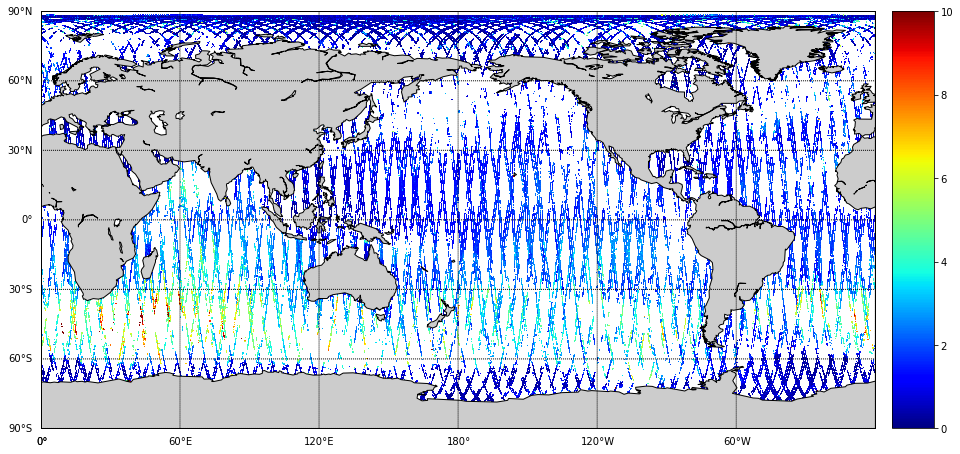

In [105]:
plt.figure(figsize=(16, 9))
is_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
# m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
is_xi, is_yi = is_m(is_x_map, is_y_map)

# Draw the scatterplot
h = is_m.pcolor(is_xi ,is_yi, data=is_grid, cmap=plt.cm.jet,vmin=0, vmax=10, latlon=True)
is_m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

is_m.drawcoastlines()
is_m.fillcontinents()
is_m.drawmapboundary()
is_m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
is_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show()

# 2.HY-2B有效波高显示

In [117]:
hy_dir_path = 'E:\python_workfile\\remote_sensing\H2B_nc_data\H2B_20200711'
hyfiles = glob.glob(hy_dir_path + '\*.nc')
hy_lon_array = np.array([])
hy_lat_array = np.array([])
hy_value_array = np.array([])
hy_swhc_mask_array = np.array([])
for hyfile in hyfiles:
    fh = Dataset(hyfile, mode='r')
    lons = fh.variables['lon'][:]
    lats = fh.variables['lat'][:]
    swhc = fh.variables['swh_c'][:]
    swhc_mask = swhc.mask
    hy_lon_array = np.append(hy_lon_array, lons)
    hy_lat_array = np.append(hy_lat_array, lats)
    hy_value_array = np.append(hy_value_array, swhc)
    hy_swhc_mask_array = np.append(hy_swhc_mask_array, swhc_mask)
    fh.close()
hy_value_array_masked = np.ma.array(hy_value_array, mask=hy_swhc_mask_array)

In [141]:
hy_lat_array.max()

80.703462

In [118]:
'''hy_lower_index = []
for i in range(len(hy_value_array_masked)):
    if hy_lat_array[i] > 60:
        hy_lower_index.append(i)

hy_lat_array = np.delete(hy_lat_array, hy_lower_index)
hy_lon_array = np.delete(hy_lon_array, hy_lower_index)
hy_value_array = np.delete(hy_value_array, hy_lower_index)
hy_swhc_mask_array = np.delete(hy_swhc_mask_array, hy_lower_index)
hy_value_array_masked = np.ma.array(hy_value_array, mask=hy_swhc_mask_array)'''

'hy_lower_index = []\nfor i in range(len(hy_value_array_masked)):\n    if hy_lat_array[i] > 60:\n        hy_lower_index.append(i)\n\nhy_lat_array = np.delete(hy_lat_array, hy_lower_index)\nhy_lon_array = np.delete(hy_lon_array, hy_lower_index)\nhy_value_array = np.delete(hy_value_array, hy_lower_index)\nhy_swhc_mask_array = np.delete(hy_swhc_mask_array, hy_lower_index)\nhy_value_array_masked = np.ma.array(hy_value_array, mask=hy_swhc_mask_array)'

In [119]:
hy_projlats,hy_projlons = transformer.transform(hy_lat_array,hy_lon_array)

In [120]:
# 获取东西半球的nlat，nlon，hy_grid_west,hy_grid_num_west
hy_nlat, hy_nlon =get_nlat_nlon_cyl(resolution)
hy_grid, hy_grid_num = get_swh_grid(hy_nlat, hy_nlon)

# 交叉点平均化
hy_grid = coincident_point_mean(hy_value_array_masked, hy_grid, hy_grid_num, hy_projlats,hy_projlons)

<ipython-input-45-ea6cdc2deb00>:26: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] = value_array[i]
<ipython-input-45-ea6cdc2deb00>:29: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] += value_array[i]


In [121]:
# 校准y坐标
hy_x = np.arange(hy_nlat)
hy_y = np.arange(hy_nlon)
hy_xx , hy_yy = np.meshgrid(hy_x * resolution, hy_y * resolution)

# 将xx,yy转换回坐标形式
hy_y_map, hy_x_map = transformer_back.transform(hy_xx , hy_yy)

In [122]:
n = np.int(hy_projlats.max() / resolution /2)
temp = np.array(hy_grid[:n])
hy_grid[0:hy_grid.shape[0]-n] = hy_grid[n:]
hy_grid[hy_grid.shape[0]-n:] = temp


In [123]:
# 校准y坐标
hy_x = np.arange(hy_nlat)
hy_y = np.arange(hy_nlon) - np.int(hy_nlon / 2)
hy_xx , hy_yy = np.meshgrid(hy_x * resolution, hy_y * resolution)

# 将xx,yy转换回坐标形式
transformer_back = pyproj.Transformer.from_crs(crs2,crs)
hy_y_map, hy_x_map = transformer_back.transform(hy_xx , hy_yy)


In [124]:
for i in range(hy_x_map.shape[0]):
    for j in range(hy_x_map.shape[1]):
        if hy_x_map[i][j]<0:
            hy_x_map[i][j] += 360

<ipython-input-142-b12fab00c1dc>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_grid, cmap=plt.cm.jet,vmin=0, vmax=10, latlon=True)


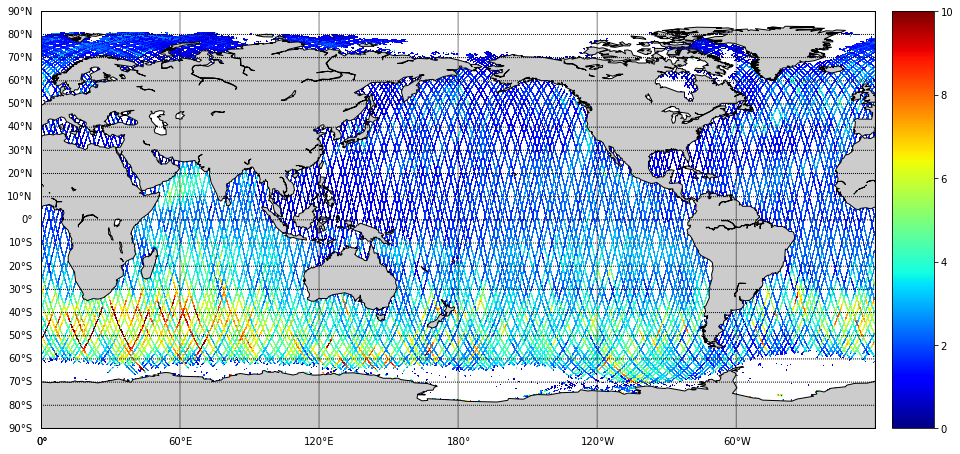

In [142]:
plt.figure(1,figsize=(16, 9))
hy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
# m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
hy_xi, hy_yi = hy_m(hy_x_map, hy_y_map)

# Draw the scatterplot
h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_grid, cmap=plt.cm.jet,vmin=0, vmax=10, latlon=True)
hy_m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

hy_m.drawcoastlines()
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show(1)

# 3. CryoSat2卫星 swh

In [67]:
cy_dir_path = 'F:\\remote_sensing_data\CRYOSAT-2\\20200701_20200711'
cyfiles = glob.glob(cy_dir_path + '\*.nc')
cy_lon_array = np.array([])
cy_lat_array = np.array([])
cy_swh_array = np.array([])
cy_swh_mask_array = np.array([])
for cyfile in cyfiles:
    with Dataset(cyfile, mode='r') as fh:
        lons = fh.variables['lon_01'][:]
        lats = fh.variables['lat_01'][:]
        swh = fh.variables['swh_ocean_01_ku'][:]
        swh_mask = swh.mask
        if np.array(swh_mask,dtype = bool).shape == ():
            swh_mask = np.full((len(swh), ), False)
        cy_lon_array = np.append(cy_lon_array, lons)
        cy_lat_array = np.append(cy_lat_array, lats)
        cy_swh_array = np.append(cy_swh_array, swh)
        cy_swh_mask_array = np.append(cy_swh_mask_array, swh_mask)
        
cy_swh_array_masked = np.ma.array(cy_swh_array, mask=cy_swh_mask_array)


In [ ]:
'''cy_lower_index = []
for i in range(len(cy_value_array_masked)):
    if cy_lat_array[i] > 60:
        cy_lower_index.append(i)

cy_lat_array = np.delete(cy_lat_array, cy_lower_index)
cy_lon_array = np.delete(cy_lon_array, cy_lower_index)
cy_value_array = np.delete(cy_value_array, cy_lower_index)
cy_swhc_mask_array = np.delete(cy_swhc_mask_array, cy_lower_index)
cy_value_array_masked = np.ma.array(cy_value_array, mask=cy_swhc_mask_array)'''

In [68]:
cy_projlats,cy_projlons = transformer.transform(cy_lat_array,cy_lon_array)

In [69]:
# 获取东西半球的nlat，nlon，cy_grid_west,cy_grid_num_west
cy_nlat, cy_nlon =get_nlat_nlon_cyl(resolution)
cy_grid, cy_grid_num = get_swh_grid(cy_nlat, cy_nlon)
# 交叉点平均化
cy_grid = coincident_point_mean(cy_swh_array_masked, cy_grid, cy_grid_num, cy_projlats,cy_projlons)

<ipython-input-45-ea6cdc2deb00>:26: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] = value_array[i]
<ipython-input-45-ea6cdc2deb00>:29: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] += value_array[i]


In [70]:
# 校准y坐标
cy_x = np.arange(cy_nlat)
cy_y = np.arange(cy_nlon) - np.int(cy_nlon / 2)
cy_xx , cy_yy = np.meshgrid(cy_x * resolution, cy_y * resolution)

# 将xx,yy转换回坐标形式
cy_y_map, cy_x_map = transformer_back.transform(cy_xx , cy_yy)

In [ ]:
n = np.int(cy_projlats.max() / resolution /2)
temp = np.array(cy_grid[:n])
cy_grid[0:cy_grid.shape[0]-n] = cy_grid[n:]
cy_grid[cy_grid.shape[0]-n:] = temp


In [ ]:
for i in range(cy_x_map.shape[0]):
    for j in range(cy_x_map.shape[1]):
        if cy_x_map[i][j]<0:
            cy_x_map[i][j] += 360

In [ ]:
plt.figure(1,figsize=(16, 9))
cy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
cy_xi, cy_yi = cy_m(cy_x_map, cy_y_map)
h = cy_m.pcolor(cy_xi ,cy_yi, data=cy_grid, cmap=plt.cm.jet,vmin=0, vmax=10)

cy_m.colorbar(location='right')
cy_m.drawcoastlines()
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 30), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show(1)
plt.close()

In [ ]:
fig = plt.figure(3)    # 生成新的画布fig
fig.set_size_inches(12,12)     # 调整画布为合适大小

ax1 = fig.add_subplot(311) 
is_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
# m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
is_xi, is_yi = is_m(is_x_map, is_y_map)

# Draw the scatterplot
h = is_m.pcolor(is_xi ,is_yi, data=is_grid, cmap=plt.cm.jet,vmin=0, vmax=10, latlon=True)
is_m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

is_m.drawcoastlines()
is_m.fillcontinents()
is_m.drawmapboundary()
is_m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
is_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("ICESAT-2 Significant Wave Height")

  

ax2 = fig.add_subplot(312)
hy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
# m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
hy_xi, hy_yi = hy_m(hy_x_map, hy_y_map)

# Draw the scatterplot
h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_grid, cmap=plt.cm.jet,vmin=0, vmax=10, latlon=True)
hy_m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

hy_m.drawcoastlines()
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("HY-2B Significant Wave Height")

ax3 = fig.add_subplot(313)

cy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
cy_xi, cy_yi = cy_m(cy_x_map, cy_y_map)
h = cy_m.pcolor(cy_xi ,cy_yi, data=cy_grid, cmap=plt.cm.jet,vmin=0, vmax=10)

cy_m.colorbar(location='right')
cy_m.drawcoastlines()
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 30), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.title("CryoSat-2 Significant Wave Height")



In [71]:
# 4. 对比HY-2B和CRYOSAT2 交叉点

In [72]:
for i in range(cy_x_map.shape[0]):
    for j in range(cy_x_map.shape[1]):
        if cy_x_map[i][j]<0:
            cy_x_map[i][j] += 360

<ipython-input-88-9aee39b17cab>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = cy_m.pcolor(cy_xi ,cy_yi, data=cy_grid, cmap=plt.cm.jet,vmin=0, vmax=10)


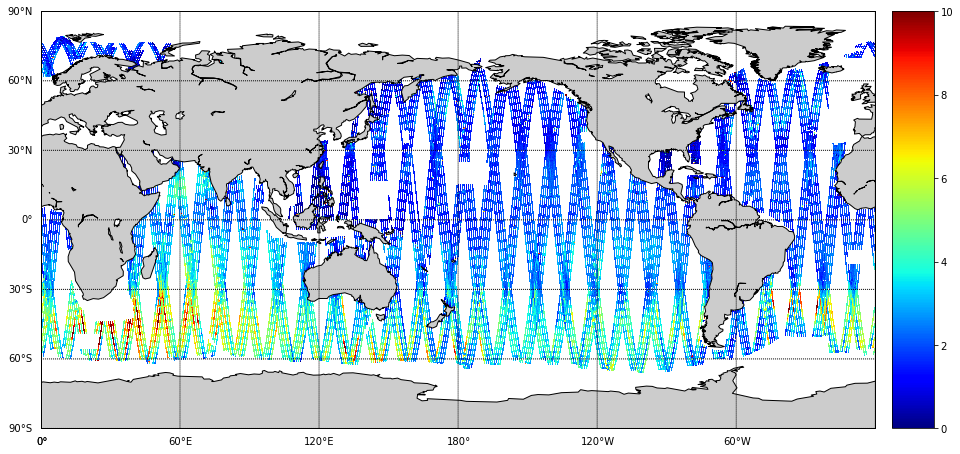

In [88]:
plt.figure(1,figsize=(16, 9))
cy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
cy_xi, cy_yi = cy_m(cy_x_map, cy_y_map)
h = cy_m.pcolor(cy_xi ,cy_yi, data=cy_grid, cmap=plt.cm.jet,vmin=0, vmax=10)

cy_m.colorbar(location='right')
cy_m.drawcoastlines()
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 30), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show(1)
plt.close()

<ipython-input-143-5c442ec5ca42>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = is_m.pcolor(is_xi ,is_yi, data=is_grid, cmap=plt.cm.jet,vmin=0, vmax=10, latlon=True)
<ipython-input-143-5c442ec5ca42>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_grid, cmap=plt.cm.jet,vmin=0, vmax=10, latlon=True)
<ipython-input-143-5c442ec5ca42>:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensi

Text(0.5, 1.0, 'CryoSat-2 Significant Wave Height')

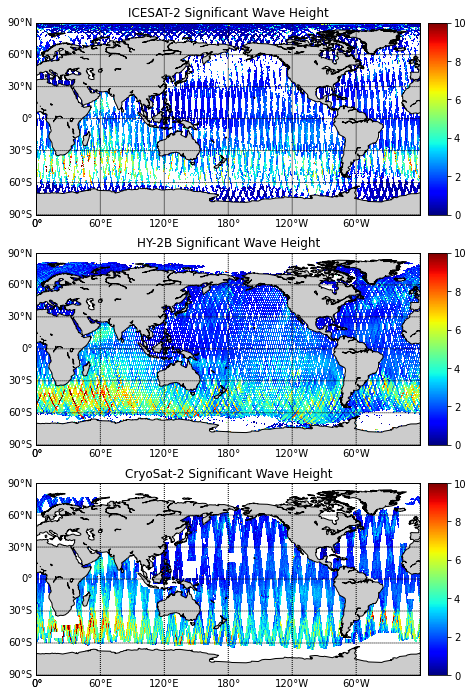

In [143]:
fig = plt.figure(3)    # 生成新的画布fig
fig.set_size_inches(12,12)     # 调整画布为合适大小

ax1 = fig.add_subplot(311) 
is_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
# m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
is_xi, is_yi = is_m(is_x_map, is_y_map)

# Draw the scatterplot
h = is_m.pcolor(is_xi ,is_yi, data=is_grid, cmap=plt.cm.jet,vmin=0, vmax=10, latlon=True)
is_m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

is_m.drawcoastlines()
is_m.fillcontinents()
is_m.drawmapboundary()
is_m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
is_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("ICESAT-2 Significant Wave Height")

  

ax2 = fig.add_subplot(312)
hy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
# m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
hy_xi, hy_yi = hy_m(hy_x_map, hy_y_map)

# Draw the scatterplot
h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_grid, cmap=plt.cm.jet,vmin=0, vmax=10, latlon=True)
hy_m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

hy_m.drawcoastlines()
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("HY-2B Significant Wave Height")

ax3 = fig.add_subplot(313)

cy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
cy_xi, cy_yi = cy_m(cy_x_map, cy_y_map)
h = cy_m.pcolor(cy_xi ,cy_yi, data=cy_grid, cmap=plt.cm.jet,vmin=0, vmax=10)

cy_m.colorbar(location='right')
cy_m.drawcoastlines()
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 30), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.title("CryoSat-2 Significant Wave Height")



# 4. 对比HY-2B和CRYOSAT2 交叉点

In [127]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_cy_grid = np.abs(hy_grid - cy_grid )
hy_cy_diff_grid = np.argwhere(np.isnan(hy_cy_grid)!= True)

In [128]:
hy_overlap_swh = np.array([])
cy_overlap_swh = np.array([])
diff_value = np.array([])
for i in range(len(hy_cy_diff_grid)):
    hy_overlap_swh = np.append(hy_overlap_swh, hy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]])
    cy_overlap_swh = np.append(cy_overlap_swh, cy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]])
    diff_value = np.append(diff_value, round(hy_cy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]], 8))


In [129]:
# 将每个交叉点的数值记入DataFrame

hy_cy_data={'HY-2B swh':hy_overlap_swh,
      'CRYOSAT swh':cy_overlap_swh,
      'Diff':diff_value
     }
hy_cy_df = pd.DataFrame(hy_cy_data)

In [130]:
print(hy_cy_df['Diff'].mean(), hy_cy_df['Diff'].std())

0.8135167517458747 0.9510557277819081


<ipython-input-147-157414d270dc>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = cy_m.pcolor(cy_xi ,cy_yi, data=hy_cy_grid, cmap=plt.cm.jet,vmin=0, vmax=2)


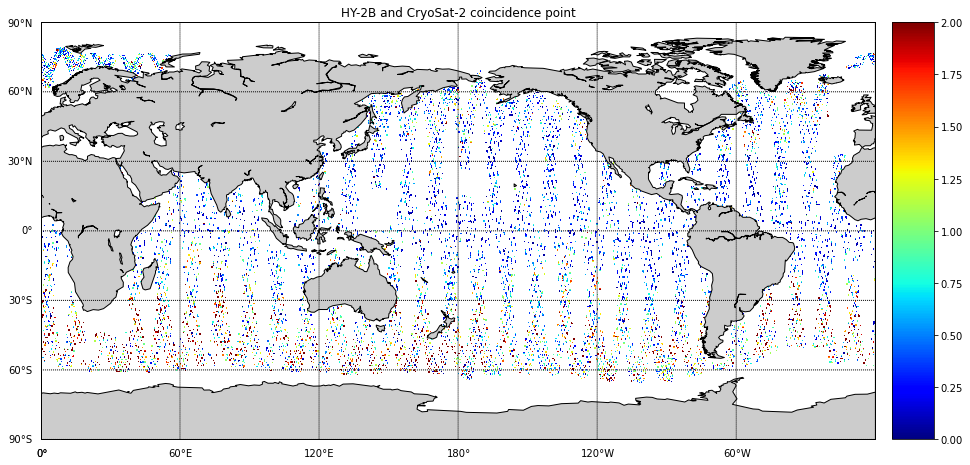

In [147]:
plt.figure(figsize=(16, 9))
cy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
cy_xi, cy_yi = cy_m(cy_x_map, cy_y_map)
h = cy_m.pcolor(cy_xi ,cy_yi, data=hy_cy_grid, cmap=plt.cm.jet,vmin=0, vmax=2)

cy_m.colorbar(location='right')
cy_m.drawcoastlines()
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 30), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("HY-2B and CryoSat-2 coincidence point")
plt.show()
plt.close()


# 5. 对比HY-2B和ICESAT2 交叉点

In [132]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_is_grid = np.abs(hy_grid - is_grid )
hy_is_diff_grid = np.argwhere(np.isnan(hy_is_grid)!= True)


In [133]:
hy_overlap_swh = np.array([])
is_overlap_swh = np.array([])
diff_value = np.array([])
for i in range(len(hy_is_diff_grid)):
    hy_overlap_swh = np.append(hy_overlap_swh, hy_grid[hy_is_diff_grid[i][0], hy_is_diff_grid[i][1]])
    is_overlap_swh = np.append(is_overlap_swh, is_grid[hy_is_diff_grid[i][0], hy_is_diff_grid[i][1]])
    diff_value = np.append(diff_value, round(hy_is_grid[hy_is_diff_grid[i][0], hy_is_diff_grid[i][1]], 8))

In [134]:
# 将每个交叉点的数值记入DataFrame

hy_is_data={'HY-2B swh':hy_overlap_swh,
      'CRYOSAT swh':is_overlap_swh,
      'Diff':diff_value
     }
hy_is_df = pd.DataFrame(hy_is_data)

In [135]:
print(hy_is_df['Diff'].mean(), hy_is_df['Diff'].std())

0.7436387566401061 0.8181483354842795


<ipython-input-138-a6d9faa82c2e>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = is_m.pcolor(is_xi ,is_yi, data=hy_is_grid, cmap=plt.cm.jet,vmin=0, vmax=2)


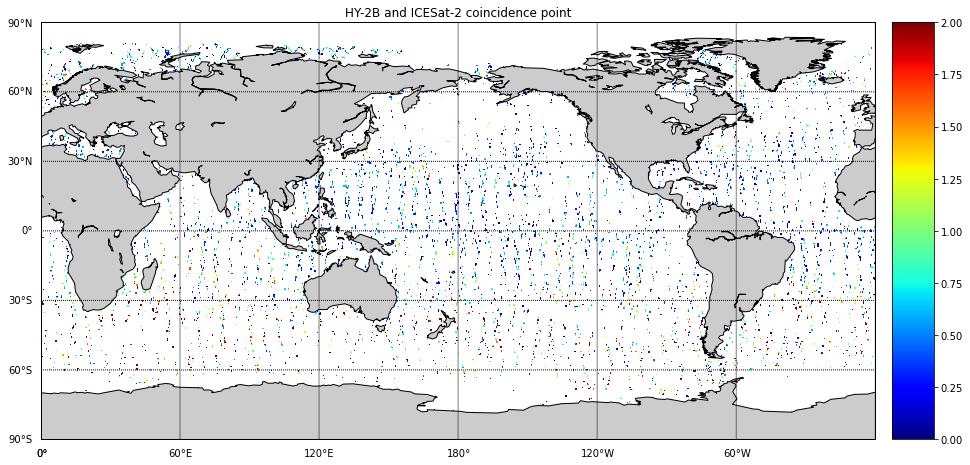

In [138]:
plt.figure(figsize=(16, 9))
is_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
is_xi, is_yi = is_m(is_x_map, is_y_map)
h = is_m.pcolor(is_xi ,is_yi, data=hy_is_grid, cmap=plt.cm.jet,vmin=0, vmax=2)

is_m.colorbar(location='right')
is_m.drawcoastlines()
is_m.fillcontinents()
is_m.drawmapboundary()
is_m.drawparallels(np.arange(-90., 120., 30), labels=[1, 0, 0, 0])
is_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.title("HY-2B and ICESat-2 coincidence point")
plt.show()
plt.close()